# Redistributing smart pools BAL rewards
This is a post processing script that redistributes BAL rewards allocated to controllers of smart pools to the actual share holders of said controllers. It requires that liquidity mining script for the week have been run and block by block reports be stored in the reports directory. It also requires access to a view in Google BigQuery that provides running balances for a subset of ERC20 tokens and holders.

In [1]:
import os
import json
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
from web3 import Web3
import matplotlib.pyplot as plt


WEEK = 25
WEEK_REPORTS_PATH = '../reports/' + str(WEEK)

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [2]:
# get receivers to redistribute
redistributers_dict = json.load(open('redistribute.json'))
redistributers_list = list(redistributers_dict.keys())

In [3]:
# get list of CRPs
sql = 'SELECT pool FROM `blockchain-etl.ethereum_balancer.CRPFactory_event_LogNewCrp`'
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
crps = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

redistributers_list.extend(crps['pool'].drop_duplicates().apply(Web3.toChecksumAddress))
print('Redistributers: {}'.format(redistributers_list))

Redistributers: ['0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F', '0xCB1a0b99755bdcaA9254219e1A22a6519b169F5f', '0xDA684a074C06D91fbf586F8D53E25646d308980f', '0x591EFb9074CdB84ea6b86AA6A55102c7dE243C7B', '0x0646Ce4edC2dFc8B20c791f5e4f96cBa48aEf6a2', '0x952E56ce38Bb5D60791D7A9c59F160Ff195a0c7C', '0x3C226E17128ede6f730bB34b3f3bc56E72a30526', '0x78aCF4c9817Df26E230eD911b33563aa91e00593', '0x3D7753c4526f8657e383a46dC41eC97414941a80', '0x03b3195EB046FdfA88aA75dABAe5829d8b99C9eD', '0x33D596fCc06463B624484E21A8C0397A8bc4191e', '0x676c782D6c2d59E3b69fe01796D6Eb475eaF93dd', '0x51A2310B37ead1D8F8Fe01B89b4Cd68FA58992d0', '0x580Ce6996F93bEAb139663E5FcD30e251E888ff8', '0x34A01C0A95B0592cc818Cd846c3Cf285d6C85A31', '0xDDFb473Eba02abA889934e883d07a9eF5C3BC31b', '0x9827e4e8e2c10120340f9009275cC9610d1e4c63', '0x9A9E04aeB02ce63aEA855Ef22519cDfa7D04C269', '0xE0b3e6f0E545121B32d02FE0952c1cA56F8AD6DB', '0x3ddD8cB6ECc202726E89e6a1dC6F95A0e1f3a0C5', '0x3209fC587454D7cF569D29213870cBFdd9A4F832', '0x9292eDa388ccf9

In [4]:
# get snapshot rewards
files = os.listdir(WEEK_REPORTS_PATH)
snapshot_files = [f for f in files if '_' not in f]
rewards_to_redistribute = {}
for f in snapshot_files:
    # filter snapshot rewards
    receiver_rewards = json.load(open(WEEK_REPORTS_PATH + '/' + f))[1]
    redistributers_rewards = dict(filter(lambda key_value: key_value[0] in redistributers_list, receiver_rewards.items()))
    rewards_to_redistribute[f[:f.find('.')]] = redistributers_rewards

In [5]:
rewards_to_redistribute_df = pd.DataFrame(rewards_to_redistribute)
rewards_to_redistribute_df.index.name = 'redistributer'
rewards_to_redistribute_df.columns.name = 'block_number'
rewards_to_redistribute_df = rewards_to_redistribute_df.melt(ignore_index=False)
rewards_to_redistribute_df.reset_index(inplace=True)
rewards_to_redistribute_df['redistributer'] = rewards_to_redistribute_df['redistributer'].apply(lambda x: x.lower())
rewards_to_redistribute_df['value'] = rewards_to_redistribute_df['value'].astype(float)
rewards_to_redistribute_df['block_number'] = rewards_to_redistribute_df['block_number'].astype(int)
rewards_to_redistribute_df

,redistributer,block_number,value
0,0x9d6c34173b603b4b2f40ae3ef3bf30d03461dab7,11285551,0.000158
1,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,11285551,0.000946
2,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11285551,0.357435
3,0x6014c068206c81d987ec88a9b9f7425e89787da7,11285551,NaN
4,0xb67090709d3213b1b2863820f5d8380ad29133a2,11285551,NaN
...,...,...,...
890,0x9d6c34173b603b4b2f40ae3ef3bf30d03461dab7,11291439,0.000158
891,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,11291439,0.000950
892,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11291439,0.356776
893,0x6014c068206c81d987ec88a9b9f7425e89787da7,11291439,NaN


In [6]:
# get redistributers' token holders
tokens = list(rewards_to_redistribute_df.redistributer.drop_duplicates())
snapshot_block_numbers = list(rewards_to_redistribute_df.block_number.drop_duplicates())
snapshot_block_numbers = [str(b) for b in snapshot_block_numbers]
sql = """
select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ({})
and block_number in ({})
and balance <> 0
""".format('\''+'\',\''.join(tokens)+'\'', 
           ','.join(snapshot_block_numbers))
print(sql)


select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ('0x9d6c34173b603b4b2f40ae3ef3bf30d03461dab7','0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed','0x49f2beff98ce62999792ec98d0ee4ad790e7786f','0x6014c068206c81d987ec88a9b9f7425e89787da7','0xb67090709d3213b1b2863820f5d8380ad29133a2')
and block_number in (11285551,11279663,11297583,11293743,11266607,11291695,11266095,11309615,11276847,11294511,11283503,11301423,11269423,11284527,11282735,11280175,11283759,11301679,11287599,11269679,11292975,11271727,11290159,11310639,11278639,11297327,11294767,11292719,11277871,11310383,11278383,11286063,11300911,11274031,11268911,11304495,11303215,11300655,11305007,11268655,11267631,11306543,11273263,11303983,11272239,11268399,11300399,11299375,11299119,11289135,11279151,11311151,11280431,11289647,11293231,11295023,11290671,11289903,11289391,11298095,11298607,11297839,11295279,11305775,11278127,11310127,11305519,11308079,11303727,11285039,11269167,11301167,112840

In [7]:
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
running_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
running_balances['balance'] = running_balances['balance'].astype(float)
running_balances = running_balances.rename(columns={"token_address": "redistributer", "address": "share_holder"})
running_balances.set_index(['block_number','redistributer','share_holder'], inplace=True)
running_balances

,,,balance
block_number,redistributer,share_holder,
11265583,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,0x0826034890984b07c428956b492b108c5863b6fe,1.000000e+20
11265839,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,0x0826034890984b07c428956b492b108c5863b6fe,1.000000e+20
11266095,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,0x0826034890984b07c428956b492b108c5863b6fe,1.000000e+20
11266351,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,0x0826034890984b07c428956b492b108c5863b6fe,1.000000e+20
11266607,0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed,0x0826034890984b07c428956b492b108c5863b6fe,1.000000e+20
...,...,...,...
11310127,0xb67090709d3213b1b2863820f5d8380ad29133a2,0x5369cf30302ea7cd8138472bd265b8522dba1061,1.000000e+11
11310383,0xb67090709d3213b1b2863820f5d8380ad29133a2,0x5369cf30302ea7cd8138472bd265b8522dba1061,1.000000e+11
11310639,0xb67090709d3213b1b2863820f5d8380ad29133a2,0x5369cf30302ea7cd8138472bd265b8522dba1061,1.000000e+11


In [8]:
shares = pd.DataFrame(running_balances['balance'])/pd.DataFrame(running_balances.groupby(['block_number','redistributer']).sum()['balance'])
shares.columns = ['perc_share']
shares.head()

perc_share
block_number redistributer                              share_holder                                          
11265583     0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed 0x0826034890984b07c428956b492b108c5863b6fe    1.000000
             0x49f2beff98ce62999792ec98d0ee4ad790e7786f 0x01673b193bbedee4c3748f3bf98e89bb80a8fa3d    0.004876
                                                        0x045b947e655b4ae46965223851cc7f922d1d19bc    0.000076
                                                        0x0a3cdf75aac28110b77b8a09f3f70427dfdc1738    0.000369
                                                        0x0be5149120375a4b5ba59352d55173c9b0283c3d    0.000152

In [9]:
rewards_to_redistribute_df.set_index(['block_number', 'redistributer'], inplace=True)
rewards_to_redistribute_df.fillna(0, inplace=True)
rewards_to_redistribute_df.head()

value
block_number redistributer                                       
11285551     0x9d6c34173b603b4b2f40ae3ef3bf30d03461dab7  0.000158
             0x03b3195eb046fdfa88aa75dabae5829d8b99c9ed  0.000946
             0x49f2beff98ce62999792ec98d0ee4ad790e7786f  0.357435
             0x6014c068206c81d987ec88a9b9f7425e89787da7  0.000000
             0xb67090709d3213b1b2863820f5d8380ad29133a2  0.000000

In [10]:
redistribution_df = pd.DataFrame(rewards_to_redistribute_df['value']*shares['perc_share']).dropna().reset_index()
redistribution_df.rename(columns={0: 'reward'}, inplace=True)
redistribution_df['share_holder'] = redistribution_df['share_holder'].apply(Web3.toChecksumAddress)
redistribution_df['redistributer'] = redistribution_df['redistributer'].apply(Web3.toChecksumAddress)

In [11]:
redistribution_df

,block_number,redistributer,share_holder,reward
0,11265583,0x03b3195EB046FdfA88aA75dABAe5829d8b99C9eD,0x0826034890984B07C428956b492b108C5863b6FE,1.187434e-03
1,11265583,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x01673B193BBEdeE4C3748f3BF98E89bb80A8fa3D,2.215239e-03
2,11265583,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x045B947E655b4AE46965223851CC7F922d1D19bc,3.468841e-05
3,11265583,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738,1.676721e-04
4,11265583,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x0be5149120375A4B5ba59352D55173C9B0283C3d,6.909005e-05
...,...,...,...,...
12712,11311151,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xfe667F5bb242473BfA5E1EAF305703f2322795cF,8.695881e-02
12713,11311151,0x6014c068206c81D987eC88A9B9F7425E89787Da7,0x1823b5C394a3bdd564E8761b9a39E0441B4c0C86,1.076314e-02
12714,11311151,0x9D6C34173B603B4B2F40AE3EF3bF30D03461Dab7,0x22Cd4027b8Af39de8eB8809588a60b8EF067eF76,1.511654e-04
12715,11311151,0xb67090709D3213b1b2863820f5D8380AD29133A2,0x1823b5C394a3bdd564E8761b9a39E0441B4c0C86,2.637797e-20


In [12]:
redistribution_df.loc[redistribution_df['reward']<0,'reward'] = 0

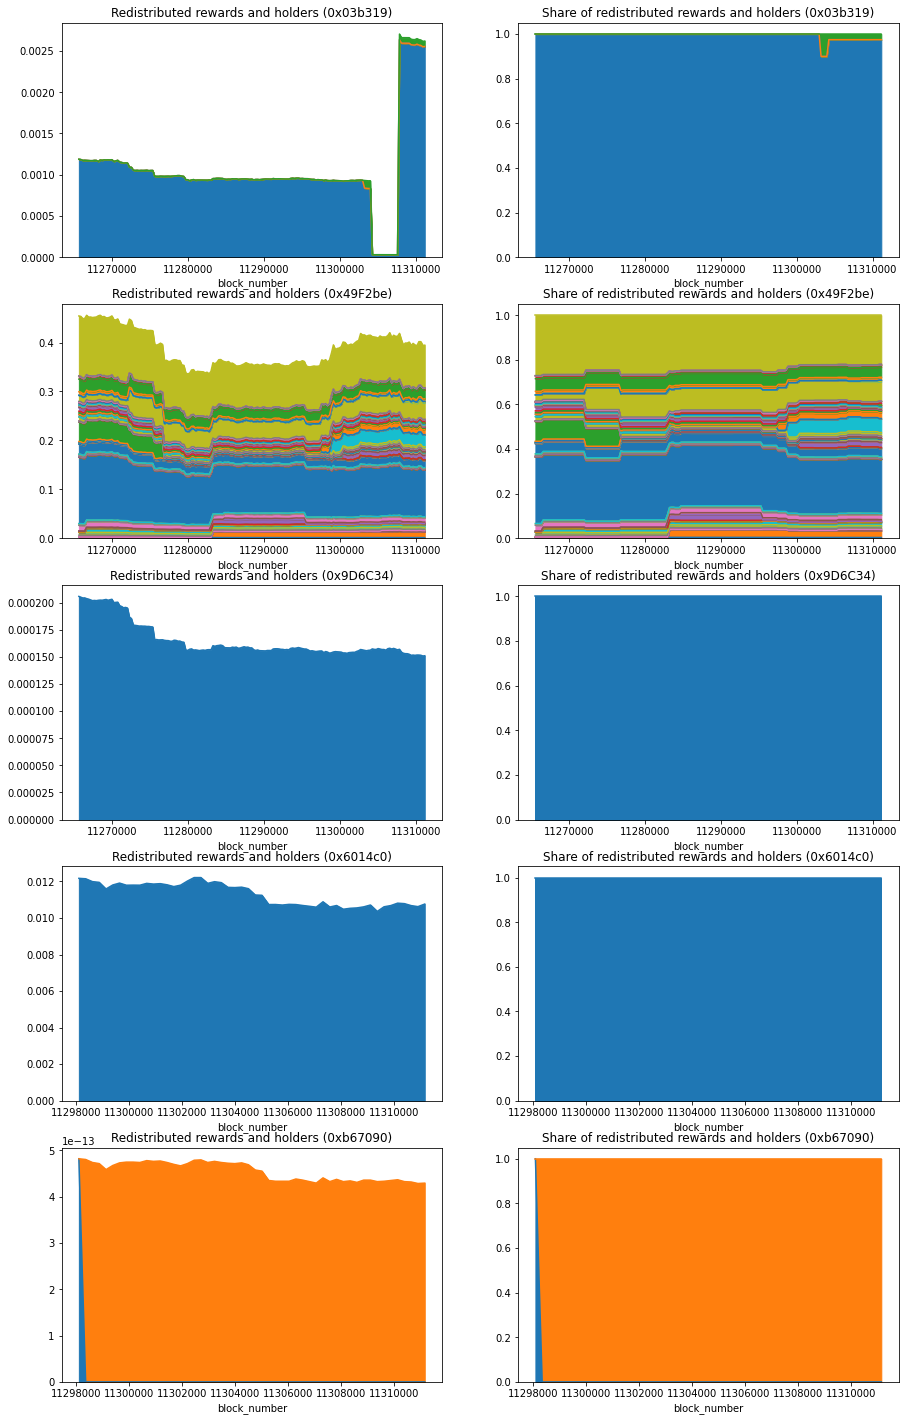

In [13]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
actual_redistributers = list(redistribution_df.redistributer.drop_duplicates())
fig, axs = plt.subplots(ncols=2, nrows=len(actual_redistributers), figsize=(15, 5*len(actual_redistributers)))
for i,t in enumerate(actual_redistributers):
    areaplot = redistribution_df[redistribution_df.redistributer==t].pivot(index='block_number', 
                                                                           columns='share_holder', 
                                                                           values='reward')
    areaplot.plot.area(legend=False, ax=axs.flat[2*i],
                       title='Redistributed rewards and holders ({})'.format(t[:8]));
    areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(legend=False, ax=axs.flat[2*i+1],
                                                            title='Share of redistributed rewards and holders ({})'.format(t[:8]));
    axs.flat[2*i].ticklabel_format(axis='x', style='plain')
    axs.flat[2*i+1].ticklabel_format(axis='x', style='plain')

In [14]:
total_redistribution = redistribution_df.groupby('share_holder').sum()['reward']
total_redistribution

share_holder
0x01673B193BBEdeE4C3748f3BF98E89bb80A8fa3D    3.080841e-01
0x045B947E655b4AE46965223851CC7F922d1D19bc    1.370978e+00
0x07df7775902C31c24eDDAC2c462B30Cf988d7e19    2.063276e-02
0x0826034890984B07C428956b492b108C5863b6FE    1.864701e-01
0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738    2.331898e-02
                                                  ...     
0xeF8305E140ac520225DAf050e2f71d5fBcC543e7    1.201175e-02
0xf9FA4901b4Cb295D12db7662079e2a8DeDDdCE08    2.919474e-02
0xf9c9C126F989df6Ea9DCe939232BE9164A69820d    1.336198e-15
0xfC6EDEB989187ff13396450d5fB6eFc4860dB1f4    4.499710e-02
0xfe667F5bb242473BfA5E1EAF305703f2322795cF    1.708831e+01
Name: reward, Length: 85, dtype: float64

In [15]:
total_pre_redistribution = json.load(open(WEEK_REPORTS_PATH + '/_totalsPreRedistribute.json'))
total_post_redistribution = total_pre_redistribution.copy()
for index,value in total_redistribution.iteritems():
    old_value = float(total_pre_redistribution.get(index,0))
    new_value = old_value + value
    if value >= 1e-18:
        total_post_redistribution[index] = format(new_value, '.18f')

for r in redistribution_df['redistributer'].drop_duplicates():
    del total_post_redistribution[r]

In [16]:
print('BAL  pre-redistribution: {:.18f}'.format(sum([float(v) for v in total_pre_redistribution.values()])))
print('BAL post-redistribution: {:.18f}'.format(sum([float(v) for v in total_post_redistribution.values()])))

BAL  pre-redistribution: 144999.999999998777639121
BAL post-redistribution: 144999.999999998894054443


In [17]:
# json.dump(total_pre_redistribution, 
#           open(WEEK_REPORTS_PATH + '/_totalsPreRedistribute.json', mode='w'),
#           indent=4)

In [18]:
json.dump(total_post_redistribution, 
          open(WEEK_REPORTS_PATH + '/_totals.json', mode='w'),
          indent=4)